In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from clearml import Task

from sklearn import linear_model
from sklearn import preprocessing

from amplify.data import DataGenerator, DataSplit

In [2]:
# ClearML Stuff
task = Task.init(project_name="amplify", task_name="power-ss-notebook")


ClearML Task: created new task id=bc4aa206a47f45db9e788ea2bce07044
2022-02-08 23:45:18,829 - clearml.Repository Detection - WARNING - Could not read Jupyter Notebook: No module named 'nbconvert'
ClearML results page: https://app.clear.ml/projects/f0e0b096252d4c18b9005e580afc5bce/experiments/bc4aa206a47f45db9e788ea2bce07044/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
2022-02-08 23:45:46,624 - clearml.Task - WARNING - ### TASK STOPPED - USER ABORTED - STATUS CHANGED ###


In [2]:
# DataGenerator - ClearML
xy_data = DataGenerator().load_data()
xy_data.head()


Info: Successfully loaded Building data!
Info: Successfully loaded Weather data!
Info: Successfully merged Building and Weather data!
Info: Calculating Azimuth and Irradiance data, this may take awhile...
Info: Successfully added Azimuth and Irradiance data!
Info: Converting Cyclical Features.
Info: Successfully converted cyclical features! Data is ready!


,temp,clouds_all,irradiance,azimuth_sin,azimuth_cos,day_of_week_sin,day_of_week_cos,True Power (kW) solar,True Power (kW) usage
2021-10-19 04:00:00+00:00,11.18,75.0,0.0,-0.37,0.93,0.43,-0.9,1.0,11.3
2021-10-19 05:00:00+00:00,9.51,20.0,0.0,0.12,0.99,0.43,-0.9,1.0,13.2
2021-10-19 06:00:00+00:00,9.28,20.0,0.0,0.56,0.83,0.43,-0.9,1.0,12.7
2021-10-19 07:00:00+00:00,9.28,20.0,0.0,0.81,0.58,0.43,-0.9,1.0,17.2
2021-10-19 08:00:00+00:00,9.28,20.0,0.0,0.93,0.36,0.43,-0.9,1.0,17.0


In [3]:
# Data Split parameters 
SERIES = 48
STRIDE = 1

In [21]:

# Split data into Train/Val/Test
train_ds, val_ds, test_ds, norm_layer = DataSplit(xy_data, series_length=SERIES, stride=STRIDE).split_data()

Info: Successfully split data into (train_x, train_y), (val_x, val_y), (test_x, test_y), (norm_layer)!


In [20]:
fig = px.line(
    xy_data,
    x=xy_data.index,
    labels={"value": "Power (kW)", "index": "Date and Time"},
    y=["True Power (kW) solar", "True Power (kW) usage"],
    title="Solar Generation and Building Usage (Power)",
)
fig.show()


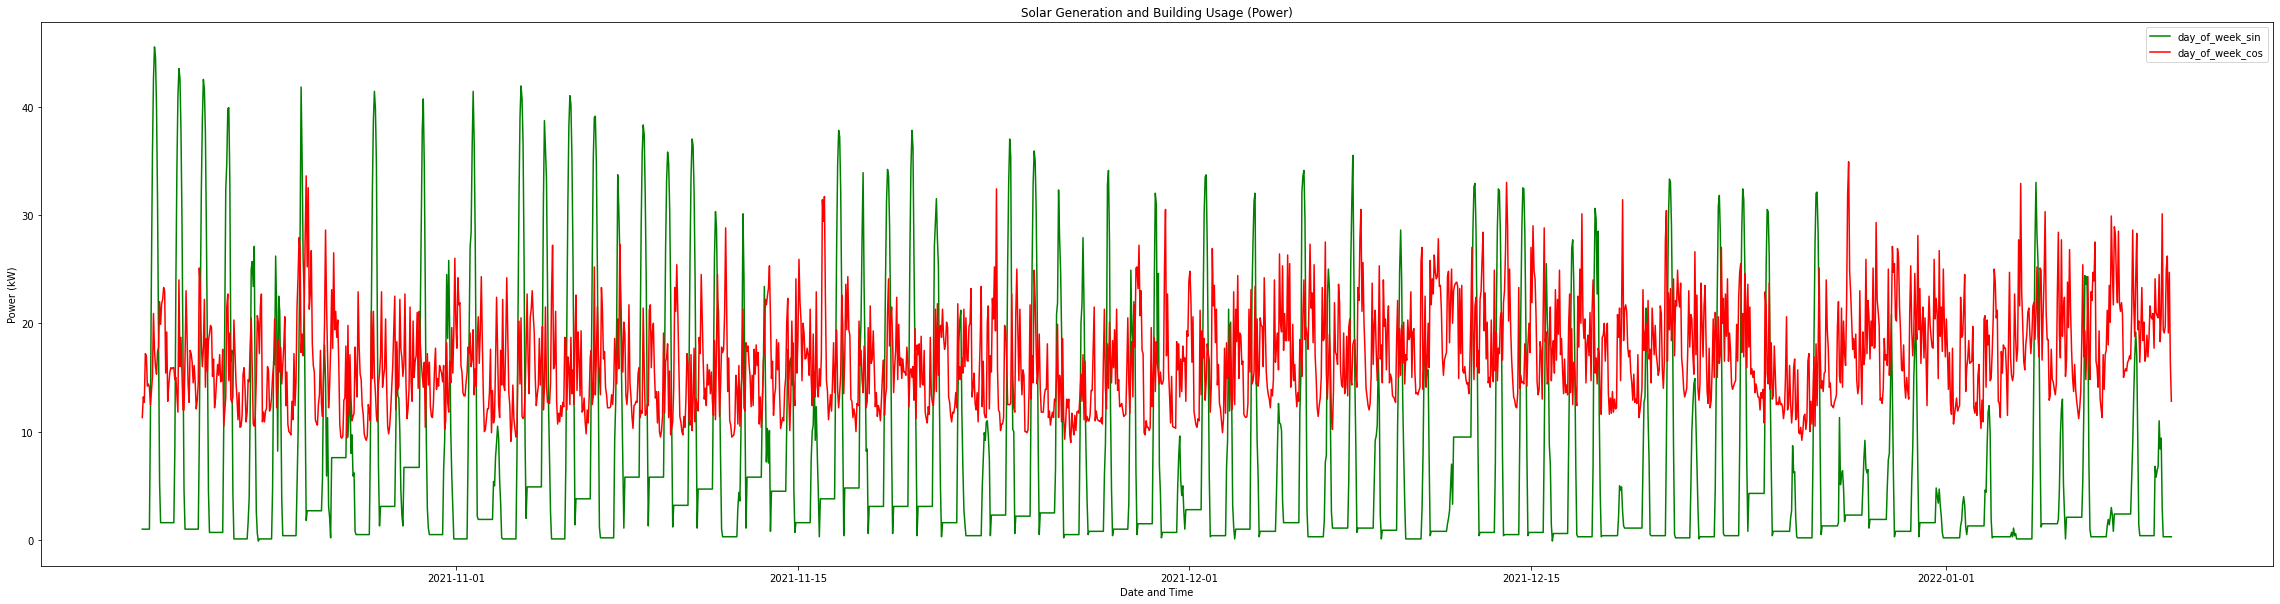

In [23]:
# Plot Power - Solar Gen vs Building Usage
fig, ax = plt.subplots(figsize=(40, 10))
plt.title("Solar Generation and Building Usage (Power)")

ax.plot(xy_data["True Power (kW) solar"], color="g")
ax.plot(xy_data["True Power (kW) usage"], color="r")

ax.set_xlabel("Date and Time")
ax.set_ylabel("Power (kW)")
plt.legend(xy_data.columns[5:7])
plt.show()


In [25]:
xy_data.to_csv('../data/xy_data.csv')

In [14]:
# Build class for EWM Linear Regression to compare scaled/non-scaled features
class Weather_EWM:
    def __init__(self, features, y, split_date, scaled=True):
        self.data = features
        self.y = y
        self.split_date = split_date
        self.scale = scaled

    # Reversed-Recombined EWMA for improved accuracy
    def ewm_calculator(self):

        # Create dataframe To collect data
        self.ewm_out = pd.DataFrame()

        # Calculate fwd and bwd EWMA
        self.ewm_out["fwd"] = self.y.ewm(span=24).mean()
        self.ewm_out["bwd"] = self.y[::-1].ewm(span=24).mean()

        # Reversed-Recombined EWMA
        self.ewm_out["combo"] = self.ewm_out.mean(axis=1)

        return self.ewm_out

    # Test/Train split and standardization of weather data
    def weather_prep(self):

        # Run ewma calculator
        self.ewm = self.ewm_calculator()

        # Test / Train split for Y based on chosen split_date
        self.ewm_train = self.ewm[self.ewm.index <= self.split_date]
        self.ewm_test = self.ewm[self.ewm.index > self.split_date]

        # Test/Train split for Weather data to match Y-data
        self.weather_train = self.data[: len(self.ewm_train)]
        self.weather_test = self.data[len(self.ewm_train) :]

        # Scale features in training set:
        if self.scale:
            self.weather_scaler = preprocessing.StandardScaler()
            self.weather_train = self.weather_scaler.fit_transform(self.weather_train)

        return self.weather_train, self.weather_test, self.ewm_train, self.ewm_test

    def weather_ewma(self):
        # Run train/test split based on date and scaling
        self.x_train, self.x_test, self.y_train, self.y_test = self.weather_prep()

        # On to the regression:
        self.lin_reg = linear_model.LinearRegression()
        self.lin_reg.fit(self.x_train, self.y_train.combo)

        self.ewm_solar_pred = self.lin_reg.predict(self.x_test)

        return self.ewm_solar_pred


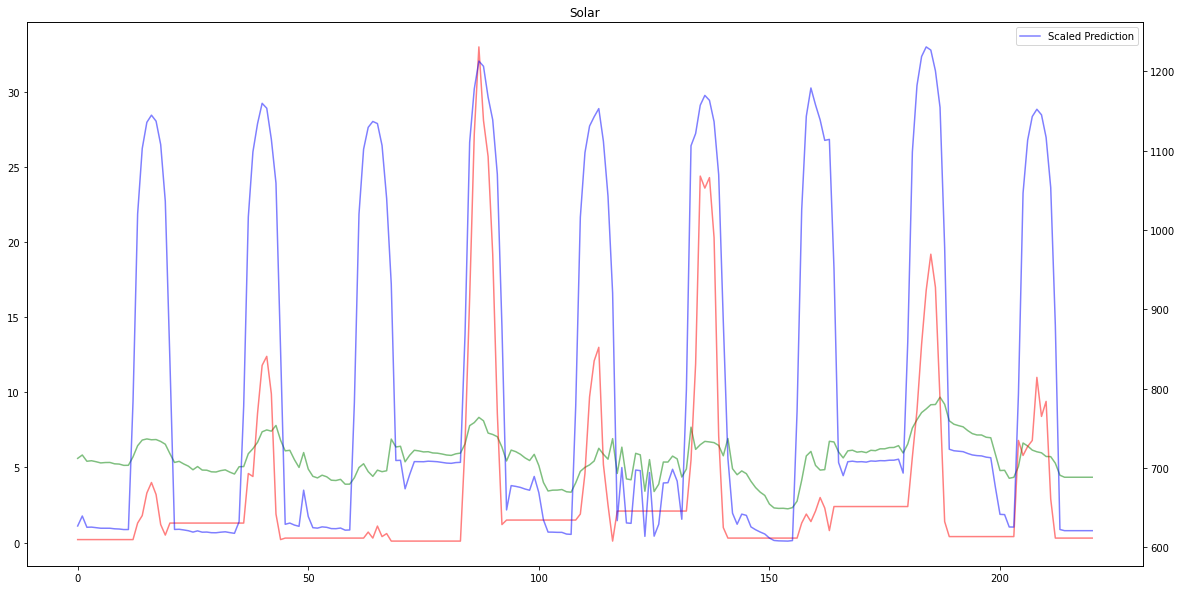

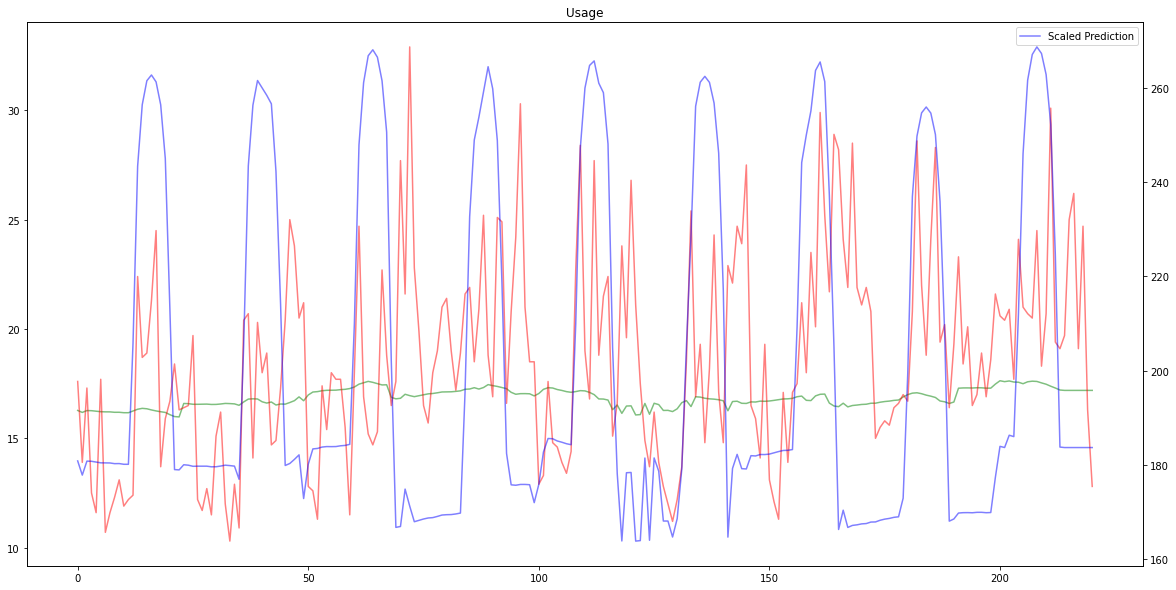

In [15]:
# Set split date for Linear Regression validation
split_date = pd.to_datetime("2022-01-01", utc=True)

# Set list of y-values we want to predict
X_vals = xy_data.drop(['solar','usage'], axis=1)
y_vals = {"Solar": xy_data.solar, "Usage": xy_data.usage}

# To run the usage and power regressions
for key in y_vals:
    # Create the separate instances for scaled/not scaled:
    WE_not_scaled = Weather_EWM(
        features=X_vals, y=y_vals[key], split_date=split_date, scaled=False
    )
    WE_scaled = Weather_EWM(features=X_vals, y=y_vals[key], split_date=split_date)

    # Run the linear regressions:
    lin_reg_scaled = WE_scaled.weather_ewma()
    lin_reg_not_scaled = WE_not_scaled.weather_ewma()

    # Plot the results
    fig, ax1 = plt.subplots(figsize=(20, 10))
    ax2 = ax1.twinx()

    # Set plot title
    title = key
    plt.title(label=title)

    # Plot prediction based on unscaled data
    ax1.plot(lin_reg_not_scaled, color="g", alpha=0.5, label="Predicted")

    # Plot prediction based on scaled data
    ax2.plot(lin_reg_scaled, color="b", alpha=0.5, label="Scaled Prediction")

    # Plot actual data
    ax1.plot(
        np.array(y_vals[key][-len(lin_reg_not_scaled) :]),
        color="r",
        alpha=0.5,
        label="Actual",
    )

    plt.xlabel("Hrs in future")
    plt.legend()
    plt.show()
